In [16]:
# Librerías utilizadas por el script
import timm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fastai.vision.all import *
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [3]:
import torch

"""
!pip install -Uqq fastbook
!pip install nbdev
"""
import fastbook

fastbook.setup_book()
import fastai
import fastcore

print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.29 installed
fastai version 2.7.14 installed


In [4]:
torch.cuda.is_available()

True

In [5]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fasst.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [6]:
df = pd.read_csv('trainSet.csv')

In [9]:
def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("/")[1]]
        return ((el['class'].values[0]))
    else:
        el = df.loc[df['image'] == str(fname).split("/")[1]]
        return ((el['class'].values[0]))

In [10]:
"""## Normalización

import os
import numpy as np
from PIL import Image

# Directorio donde se encuentran las imágenes
directorio_imagenes = "trainThumbnails"

# Lista para almacenar los valores de brillo promedio de las imágenes
im_colors = []

# Recorre todas las imágenes en el directorio
for filename in os.listdir(directorio_imagenes):
    ruta_completa = os.path.join(directorio_imagenes, filename)
    imagen = Image.open(ruta_completa)
    # Calcula el brillo promedio de la imagen (puedes adaptar esto según tus necesidades)
    media = np.mean(imagen)
    im_colors.append(media)

# Calcula la media y la desviación estándar de los valores de brillo
med_col= np.mean(im_colors)
desv_col = np.std(im_colors)

print(f"Media: {med_col:.2f}")
print(f"Desviación estándar: {desv_col:.2f}")"""

'## Normalización\n\nimport os\nimport numpy as np\nfrom PIL import Image\n\n# Directorio donde se encuentran las imágenes\ndirectorio_imagenes = "trainThumbnails"\n\n# Lista para almacenar los valores de brillo promedio de las imágenes\nim_colors = []\n\n# Recorre todas las imágenes en el directorio\nfor filename in os.listdir(directorio_imagenes):\n    ruta_completa = os.path.join(directorio_imagenes, filename)\n    imagen = Image.open(ruta_completa)\n    # Calcula el brillo promedio de la imagen (puedes adaptar esto según tus necesidades)\n    media = np.mean(imagen)\n    im_colors.append(media)\n\n# Calcula la media y la desviación estándar de los valores de brillo\nmed_col= np.mean(im_colors)\ndesv_col = np.std(im_colors)\n\nprint(f"Media: {med_col:.2f}")\nprint(f"Desviación estándar: {desv_col:.2f}")'

In [11]:
# División en 70% train y 30% validación

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.3, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(224, method='squish')],  # Redimensionado
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()]
).dataloaders("trainThumbnails/", bs=64)

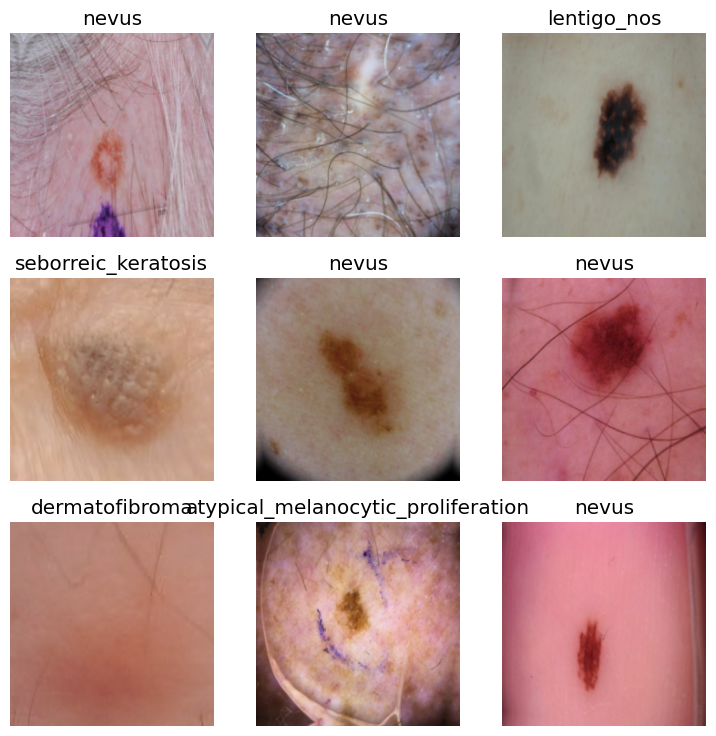

In [12]:
trainSet.show_batch()  # shows a batch of images

In [13]:
def ghm_c_loss(y_pred, y_true, bins=10):
    # Compute gradient norm 
    probs = torch.sigmoid(y_pred, dim=1)
    gradient_norm = torch.abs(probs - y_true)

    # Bin the gradients
    min_val, max_val = gradient_norm.min(), gradient_norm.max()
    bin_width = (max_val - min_val) / bins
    gradient_bins = torch.floor((gradient_norm - min_val) / bin_width).long()

    # Calculate gradient density
    bin_counts = torch.bincount(gradient_bins)
    total_count = bin_counts.sum()
    gradient_density = bin_counts / total_count

    # Get bin id for each example
    bin_ids = gradient_bins[torch.arange(len(gradient_norm)), gradient_norm]

    # Compute loss 
    weights = 1 / (gradient_density[bin_ids] + 1e-6)
    ce_loss = nn.functional.binary_cross_entropy_with_logits(y_pred, y_true)
    weighted_loss = ce_loss * weights

    return weighted_loss.mean()

In [14]:
efnet_3 = timm.create_model('tf_efficientnet_lite1', pretrained=True)
efnet_3.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
   

In [15]:
efnet_3_learner = Learner(trainSet, efnet_3, loss_func=FocalLoss(), metrics=[accuracy, error_rate])
efnet_3_learner.summary()

EfficientNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2dSame                                864        True      
Identity                                                       
ReLU6                                                          
Conv2d                                    288        True      
Identity                                                       
ReLU6                                                          
Identity                                                       
____________________________________________________________________________
                     64 x 16 x 112 x 112 
Conv2d                                    512        True      
Identity                                                       
Identity                                                       
____________________________________________________________________________
           

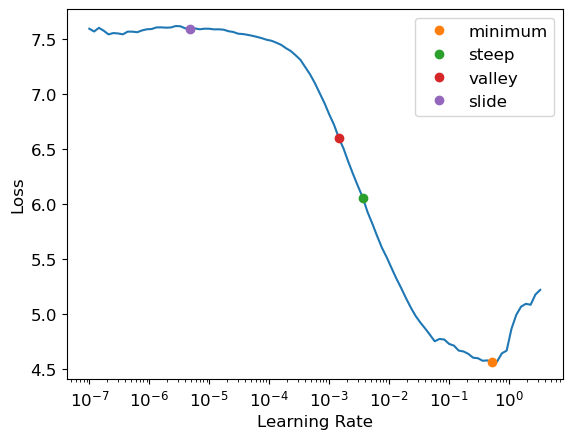

In [16]:
lrs = efnet_3_learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [17]:
print("Valores propuestos: ", lrs)
print("\nValle (Smith Fit One cycle)", lrs[2])

Valores propuestos:  SuggestedLRs(minimum=0.05248074531555176, steep=0.00363078061491251, valley=0.0014454397605732083, slide=4.786300905834651e-06)

Valle (Smith Fit One cycle) 0.0014454397605732083


In [18]:
# Etapa 1: Entrenamiento de la última capa
efnet_3_learner.freeze()
efnet_3_learner.fine_tune(1)
# Etapa 2: Descongelar y entrenar
efnet_3_learner.unfreeze()
efnet_3_learner.fit_one_cycle(20, lrs[2], cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3), wd=1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.023370,1.028816,0.552148,0.447852,03:43


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.599439,0.598083,0.703350,0.296650,03:46


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.517272,0.563055,0.714447,0.285553,03:45
1,0.541746,0.610021,0.693280,0.306720,03:44
2,0.610221,0.673939,0.677199,0.322801,03:43


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.517272,0.563055,0.714447,0.285553,03:45
1,0.541746,0.610021,0.693280,0.306720,03:44
2,0.610221,0.673939,0.677199,0.322801,03:43
3,0.651639,0.672852,0.673448,0.326552,03:46


In [19]:
interp = ClassificationInterpretation.from_learner(efnet_3_learner, 1, trainSet.valid)

preds, targets = efnet_3_learner.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [20]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")

Balanced accuracy: 31.8280
Precision: 67.9081
F1 Score: 66.2683


/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

report = classification_report(y_true, y_pred, target_names=trainSet.vocab)
print(report)

                                    precision    recall  f1-score   support

                       acrochordon       0.13      0.20      0.16        45
                 actinic_keratosis       0.44      0.66      0.53       981
                              aimp       0.21      0.12      0.16        24
                     angiokeratoma       0.75      0.12      0.21        24
                           angioma       0.50      0.10      0.17        10
                      angiosarcoma       0.00      0.00      0.00        12
                    atypical nevus       0.36      0.29      0.32        14
atypical_melanocytic_proliferation       0.00      0.00      0.00        17
              basal_cell_carcinoma       0.67      0.63      0.65      1640
                      becker_nevus       0.56      0.42      0.48        12
                        blue_nevus       1.00      0.11      0.20        71
                  congenital_nevus       0.00      0.00      0.00        18
           

/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Clasificación binaria

In [29]:
print(df['class'].unique())

['squamous_cell_carcinoma' 'melanoma' 'actinic_keratosis' 'dermatofibroma' 'nevus' 'melanocytic_nevus' 'basal_cell_carcinoma' 'angiokeratoma' 'melanoma_metastatis' 'wart' 'seborreic_keratosis'
 'neurofibroma' 'hemangioma' 'syringoma' 'epidermal_cyst' 'pyogenic_granuloma' 'intraepithelial_carcinoma' 'lentigo_nos' 'acrochordon' 'pigmented_benign_keratosis' 'solar_lentigo' 'becker_nevus'
 'congenital_nevus' 'poroma' 'venous_lake' 'blue_nevus' 'skin_tag' 'organoid_nevus' 'verruca' 'atypical nevus' 'mucosal_melanotic_macule' 'mucocele' 'epidermal_nevus' 'port_wine_stain'
 'kaposi_sarcoma' 'atypical_melanocytic_proliferation' 'lichenoid_keratosis' 'sebaceous_hyperplasia' 'lentigo_simplex' 'xanthelasma' 'aimp' 'angioma' 'vascular_lesion' 'poro_keratosis' 'milia' 'dfsp'
 'lymphangioma' 'spitz_nevus' 'ota_nevus' 'melanoma_metastasis' 'angiosarcoma' 'scar' 'keratoacanthoma']


In [7]:
malignant = ['squamous_cell_carcinoma' 'melanoma', 'basal_cell_carcinoma', 'melanoma_metastatis',
             'intraepithelial_carcinoma', 'kaposi_sarcoma', 'angiosarcoma']


def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("/")[1]]
    else:
        el = df.loc[df['image'] == str(fname).split("/")[1]]

    if (el['class'].values[0]) in malignant:
        return 1
    else:
        return 0

In [8]:
# División en 70% train y 30% validación

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.3, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(224, method='squish')],  # Redimensionado
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()]
).dataloaders("trainThumbnails/", bs=64)

In [11]:
efnet_3 = timm.create_model('tf_efficientnet_lite1', pretrained=True)
efnet_3.eval()
efnet_bin_learner = Learner(trainSet, efnet_3, loss_func=FocalLoss(), metrics=[accuracy, error_rate])
efnet_bin_learner.summary()

EfficientNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2dSame                                864        True      
Identity                                                       
ReLU6                                                          
Conv2d                                    288        True      
Identity                                                       
ReLU6                                                          
Identity                                                       
____________________________________________________________________________
                     64 x 16 x 112 x 112 
Conv2d                                    512        True      
Identity                                                       
Identity                                                       
____________________________________________________________________________
           

Valores propuestos:  SuggestedLRs(minimum=0.03019951581954956, steep=0.0010000000474974513, valley=0.0012022644514217973, slide=1.3182567499825382e-06)

Valle (Smith Fit One cycle) 0.0012022644514217973


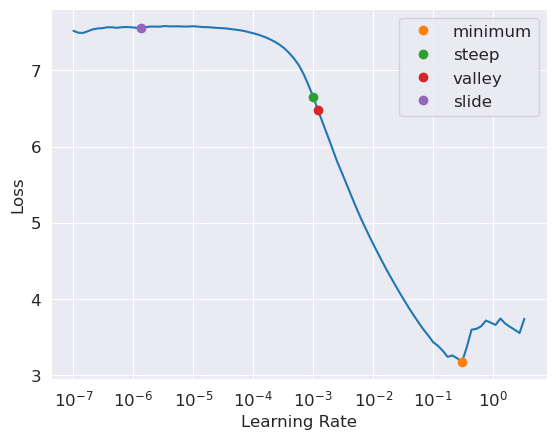

In [12]:
lrs = efnet_bin_learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

print("Valores propuestos: ", lrs)
print("\nValle (Smith Fit One cycle)", lrs[2])

In [13]:
# Etapa 1: Entrenamiento de la última capa
efnet_bin_learner.freeze()
efnet_bin_learner.fine_tune(1)
# Etapa 2: Descongelar y entrenar
efnet_bin_learner.unfreeze()
efnet_bin_learner.fit_one_cycle(20, lrs[2], cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3), wd=1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.065401,0.065193,0.912043,0.087957,03:43


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.048118,0.045974,0.933929,0.066071,03:43


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.043176,0.044468,0.934700,0.065300,03:46
1,0.044174,0.045232,0.932388,0.067612,03:50
2,0.048418,0.052780,0.932080,0.067920,03:50


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.043176,0.044468,0.934700,0.065300,03:46
1,0.044174,0.045232,0.932388,0.067612,03:50
2,0.048418,0.052780,0.932080,0.067920,03:50
3,0.048050,0.057882,0.907059,0.092941,03:45


In [14]:
interp = ClassificationInterpretation.from_learner(efnet_bin_learner, 1, trainSet.valid)

preds, targets = efnet_bin_learner.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [18]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     17616
           1       0.51      0.60      0.55      1848

    accuracy                           0.91     19464
   macro avg       0.73      0.77      0.75     19464
weighted avg       0.91      0.91      0.91     19464



In [19]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")

Balanced accuracy: 77.1137
Precision: 91.4966
F1 Score: 91.0549
